In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import shap

# Define specific time points for interpolation
interp_time_points = [1, 2, 3]
num_interp_pts = len(interp_time_points)
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50
# ----------------------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')
# Encode categorical
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)
# ----------------------
# Interpolation at specific time points (1, 2, 3)
# ----------------------
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    # Interpolate at fixed time points
    interp_release = np.interp(interp_time_points, g['Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Time_interp': interp_time_points,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

In [32]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ----------------------------------------------------------------------------------------
# Prepare X and y
# ----------------------------------------------------------------------------------------
X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
y = interp_df.pivot(index='Formulation Index', columns='Time_interp', values='Interpolated Release').to_numpy()
# Shape: (n_formulations, 3)

# ----------------------------------------------------------------------------------------
# Model wrapper for Random Forest
# ----------------------------------------------------------------------------------------
class RandomForestModel:
    def __init__(self, **params):
        self.model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse

# ----------------------------------------------------------------------------------------
# Nested CV setup
# ----------------------------------------------------------------------------------------
outer_kf = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)

# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
stored_best_models = []
stored_best_preds = []
stored_test_targets = []
stored_best_rmse = []
stored_best_mse = []
stored_corr = []
stored_pval = []
all_outer_train_loss_curves_best = []
stored_shap_values = []
stored_shap_test_sets = []

# ----------------------------------------------------------------------------------------
# Outer CV loop
# ----------------------------------------------------------------------------------------
for outer_fold, (train_idx, test_idx) in enumerate(outer_kf.split(X, y)):
    print(f"\nOuter Fold {outer_fold + 1}")
    X_train_val, y_train_val = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    stored_test_targets.append(y_test)

    # ----------------------------------------------------------------------------------------
    # Optuna objective for inner CV
    # ----------------------------------------------------------------------------------------
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
        }
        val_losses = []
        for inner_train_idx, inner_val_idx in inner_kf.split(X_train_val, y_train_val):
            X_tr, X_val = X_train_val[inner_train_idx], X_train_val[inner_val_idx]
            y_tr, y_val = y_train_val[inner_train_idx], y_train_val[inner_val_idx]
            model = RandomForestModel(**params)
            model.fit(X_tr, y_tr)
            val_losses.append(model.evaluate(X_val, y_val))
        return np.mean(val_losses)

    # ----------------------------------------------------------------------------------------
    # Run Optuna study
    # ----------------------------------------------------------------------------------------
    tpe_sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=tpe_sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_params = study.best_params
    print("Best params:", best_params)

    # ----------------------------------------------------------------------------------------
    # Train best model on full training data
    # ----------------------------------------------------------------------------------------
    best_model = RandomForestModel(**best_params)
    best_model.fit(X_train_val, y_train_val)
    preds_best = best_model.predict(X_test)

    # ----------------------------------------------------------------------------------------
    # Calculate and store SHAP values on the outer test set
    # ----------------------------------------------------------------------------------------
    print("Calculating SHAP values for the outer test set...")
    np.random.seed(42)
    explainer = shap.TreeExplainer(best_model.model)
    shap_values = explainer.shap_values(X_test)
    stored_shap_values.append(shap_values)
    stored_shap_test_sets.append(X_test)

    # ----------------------------------------------------------------------------------------
    # Compute metrics
    # ----------------------------------------------------------------------------------------
    mse_best = mean_squared_error(y_test, preds_best)
    rmse_best = np.sqrt(mse_best)
    
    # Flatten for correlation
    corr_best, pval_best = pearsonr(y_test.flatten(), preds_best.flatten())

    # Per-timepoint metrics
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(y_test[:, i], preds_best[:, i]))
        corr_t, _ = pearsonr(y_test[:, i], preds_best[:, i])
        print(f"  Time {t}: RMSE={rmse_t:.4f}, Corr={corr_t:.4f}")

    # ----------------------------------------------------------------------------------------
    # Store results
    # ----------------------------------------------------------------------------------------
    stored_best_models.append(best_model)
    stored_best_preds.append(preds_best)
    stored_best_mse.append(mse_best)
    stored_best_rmse.append(rmse_best)
    stored_corr.append(corr_best)
    stored_pval.append(pval_best)
    all_outer_train_loss_curves_best.append([mse_best])

    print(
        f"Fold {outer_fold+1} Overall - "
        f"RMSE: {rmse_best:.4f}, "
        f"Corr: {corr_best:.4f}, "
        f"p-val: {pval_best:.2e}"
    )

# ----------------------------------------------------------------------------------------
# Summary
# ----------------------------------------------------------------------------------------
print("\n" + "="*60)
print("SUMMARY ACROSS ALL FOLDS")
print("="*60)
print(f"Mean RMSE: {np.mean(stored_best_rmse):.4f} ± {np.std(stored_best_rmse):.4f}")
print(f"Mean Corr: {np.mean(stored_corr):.4f} ± {np.std(stored_corr):.4f}")


Outer Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 246, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1580, Corr=0.5833
  Time 2: RMSE=0.1817, Corr=0.5981
  Time 3: RMSE=0.1955, Corr=0.6143
Fold 1 Overall - RMSE: 0.1791, Corr: 0.6274, p-val: 3.69e-12

Outer Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 159, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1133, Corr=0.6781
  Time 2: RMSE=0.1425, Corr=0.7080
  Time 3: RMSE=0.1661, Corr=0.6967
Fold 2 Overall - RMSE: 0.1423, Corr: 0.7192, p-val: 1.54e-16

Outer Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 144, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1796, Corr=0.4973
  Time 2: RMSE=0.1878, Corr=0.5634
  Time 3: RMSE=0.2048, Corr=0.5760
Fold 3 Overall - RMSE: 0.1910, Corr: 0.5997, p-val: 1.07e-10

Outer Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 148, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1527, Corr=0.5589
  Time 2: RMSE=0.1705, Corr=0.5807
  Time 3: RMSE=0.1805, Corr=0.5881
Fold 4 Overall - RMSE: 0.1683, Corr: 0.6120, p-val: 3.49e-11

Outer Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 269, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1507, Corr=0.7275
  Time 2: RMSE=0.1814, Corr=0.6407
  Time 3: RMSE=0.1861, Corr=0.6394
Fold 5 Overall - RMSE: 0.1734, Corr: 0.6754, p-val: 4.41e-14

Outer Fold 6


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 188, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1715, Corr=0.5804
  Time 2: RMSE=0.2002, Corr=0.5702
  Time 3: RMSE=0.2162, Corr=0.5777
Fold 6 Overall - RMSE: 0.1968, Corr: 0.5961, p-val: 1.48e-10

Outer Fold 7


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 256, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.0942, Corr=0.8572
  Time 2: RMSE=0.1123, Corr=0.8416
  Time 3: RMSE=0.1263, Corr=0.8253
Fold 7 Overall - RMSE: 0.1117, Corr: 0.8456, p-val: 2.30e-27

Outer Fold 8


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1502, Corr=0.5453
  Time 2: RMSE=0.1649, Corr=0.6046
  Time 3: RMSE=0.1678, Corr=0.6363
Fold 8 Overall - RMSE: 0.1611, Corr: 0.6270, p-val: 8.21e-12

Outer Fold 9


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 230, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1735, Corr=0.6705
  Time 2: RMSE=0.2175, Corr=0.6406
  Time 3: RMSE=0.2371, Corr=0.6396
Fold 9 Overall - RMSE: 0.2110, Corr: 0.6659, p-val: 1.33e-13

Outer Fold 10


  0%|          | 0/50 [00:00<?, ?it/s]

Best params: {'n_estimators': 279, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}
Calculating SHAP values for the outer test set...
  Time 1: RMSE=0.1277, Corr=0.7735
  Time 2: RMSE=0.1439, Corr=0.7687
  Time 3: RMSE=0.1541, Corr=0.7916
Fold 10 Overall - RMSE: 0.1423, Corr: 0.7887, p-val: 1.44e-21

SUMMARY ACROSS ALL FOLDS
Mean RMSE: 0.1677 ± 0.0281
Mean Corr: 0.6757 ± 0.0803


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
all_preds = np.vstack(stored_best_preds)
all_targets = np.vstack(stored_test_targets)

for i, t in enumerate(interp_time_points):
    ax = axes[i]
    ax.scatter(all_targets[:, i], all_preds[:, i], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Ideal')
    ax.set_xlabel("Actual Release", fontsize=14)
    ax.set_ylabel("Predicted Release", fontsize=14)
    ax.set_title(f"Time = {t*24}h", fontsize=16)
    corr, _ = pearsonr(all_targets[:, i], all_preds[:, i])
    ax.text(0.05, 0.95, f"corr = {corr:.3f}", transform=ax.transAxes, fontsize=12, va='top')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3278117/962789754.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False)


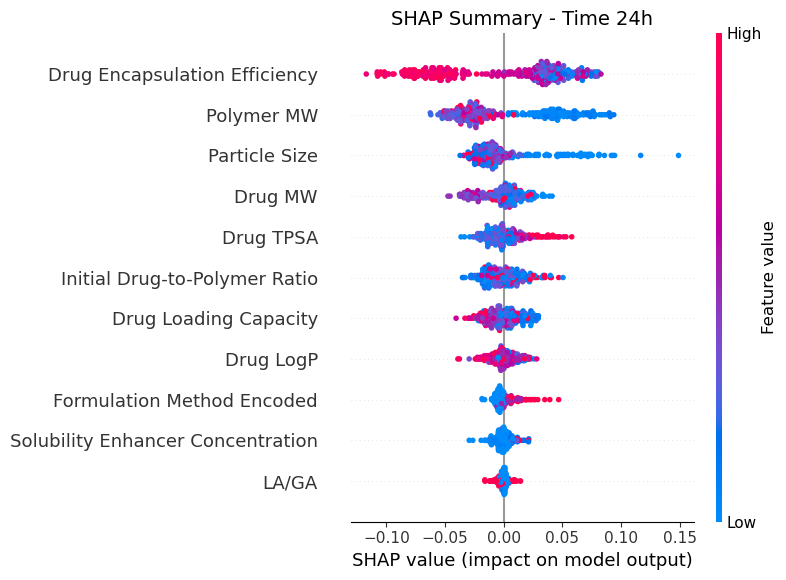

/tmp/ipykernel_3278117/962789754.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False)


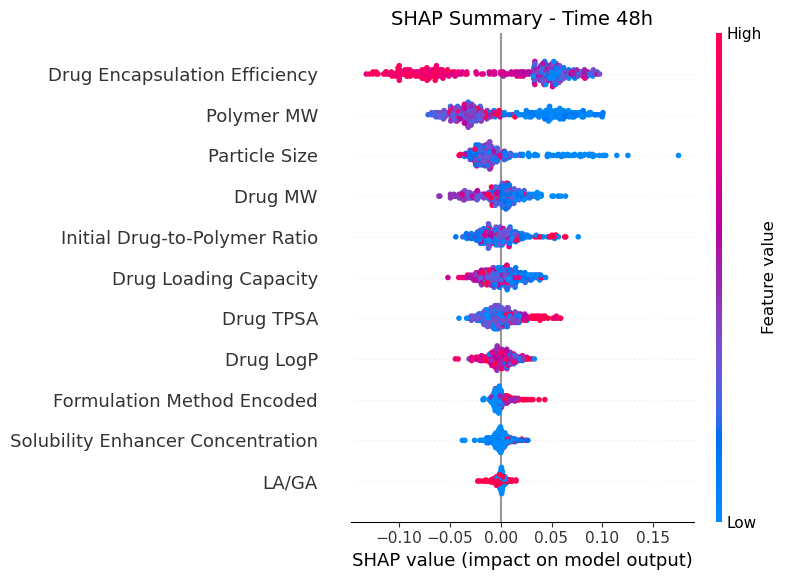

/tmp/ipykernel_3278117/962789754.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False)


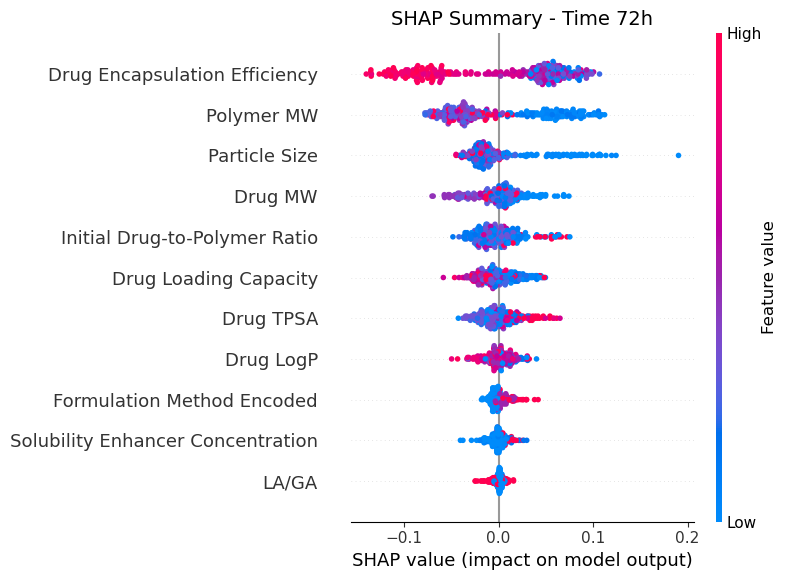

In [21]:
feature_names = formulation_df.drop(columns=['Formulation Index']).columns.tolist()
all_X_test = np.vstack(stored_shap_test_sets)

# Concatenate across folds: shape (n_total_samples, n_features, n_outputs)
all_shap = np.vstack(stored_shap_values)

for i, t in enumerate(interp_time_points):
    # Extract shap values for output i: shape (n_samples, n_features)
    shap_for_output_i = all_shap[:, :, i]
    
    plt.figure()
    shap.summary_plot(shap_for_output_i, all_X_test, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary - Time {t*24}h", fontsize=14)
    plt.tight_layout()
    plt.show()

In [29]:
# Storage per timepoint
rmse_per_timepoint = {t: [] for t in interp_time_points}
corr_per_timepoint = {t: [] for t in interp_time_points}
pval_per_timepoint = {t: [] for t in interp_time_points}  # NEW
adj_r2_per_timepoint = {t: [] for t in interp_time_points}
p = X.shape[1]

for preds, targets in zip(stored_best_preds, stored_test_targets):
    n = len(targets)
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(targets[:, i], preds[:, i]))
        rmse_per_timepoint[t].append(rmse_t)
        
        corr_t, pval_t = pearsonr(targets[:, i], preds[:, i])  # capture p-value
        corr_per_timepoint[t].append(corr_t)
        pval_per_timepoint[t].append(pval_t)  # NEW
        
        r2_t = r2_score(targets[:, i], preds[:, i])
        adj_r2_t = 1 - (1 - r2_t) * (n - 1) / (n - p - 1)
        adj_r2_per_timepoint[t].append(adj_r2_t)

# Print summary
print(f"{'Time':<10} {'RMSE':<20} {'Correlation (p-val)':<25} {'Adj R2':<20}")
print("=" * 75)
for t in interp_time_points:
    rmse_mean, rmse_std = np.mean(rmse_per_timepoint[t]), np.std(rmse_per_timepoint[t])
    corr_mean = np.mean(corr_per_timepoint[t])
    pval_mean = np.mean(pval_per_timepoint[t])  # or use median for p-values
    adj_r2_mean, adj_r2_std = np.mean(adj_r2_per_timepoint[t]), np.std(adj_r2_per_timepoint[t])
    print(f"{t}h{'':<8} {rmse_mean:.4f} ± {rmse_std:.4f}    {corr_mean:.4f} (p={pval_mean:.2e})    {adj_r2_mean:.4f} ± {adj_r2_std:.4f}")

Time       RMSE                 Correlation (p-val)       Adj R2              
24h         0.1471 ± 0.0261    0.6472 (p=6.83e-04)    0.0656 ± 0.2382
48h         0.1703 ± 0.0292    0.6517 (p=2.58e-04)    0.0817 ± 0.2072
72h         0.1834 ± 0.0304    0.6585 (p=1.90e-04)    0.0875 ± 0.1989
